In [57]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

In [58]:
def lorentzian(x, A, x0, gamma):
    return A * (gamma / 2)**2 / ((x - x0)**2 + (gamma / 2)**2)

def multi_lorentzian(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        A = params[i]
        x0 = params[i + 1]
        gamma = params[i + 2]
        y += lorentzian(x, A, x0, gamma)
    return y

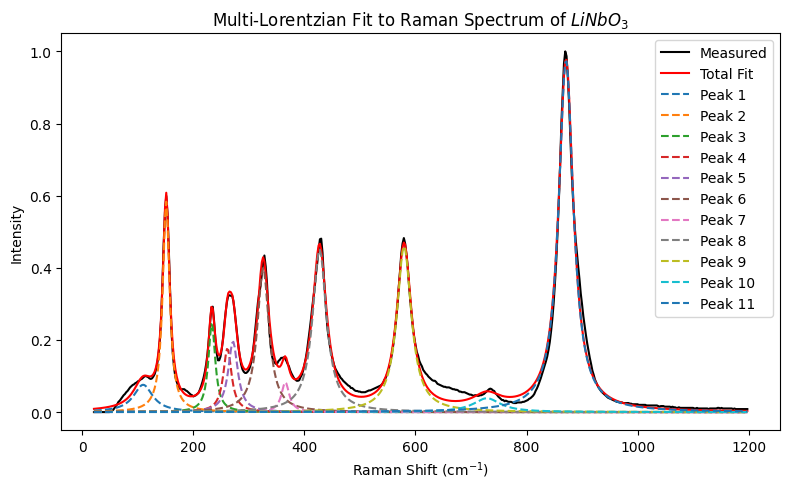

In [63]:
data = np.loadtxt("raman_data_LNB.txt", skiprows=1)
x = data[:, 0]
y = data[:, 1]

peaks, properties = find_peaks(
    y,
    height=0.01,        # minimum peak height
    distance=5,      # minimum distance between peaks
    prominence=0.005     # peak prominence
)

initial_guess = np.array([])
lower_bounds = np.array([])
upper_bounds = np.array([])

for i in range(len(peaks)):
    d_wn = [11,30,10,20,25,20,10,20,20,20,20]
    rng = (x>x[peaks[i]]-d_wn[i]) & (x<x[peaks[i]]+d_wn[i])
    x_rng = x[rng]
    y_rng = y[rng]
    popt, pcov = curve_fit(lorentzian, x_rng, y_rng, p0=[1,x[peaks[i]],1])
    initial_guess = np.append(initial_guess, popt[0])
    initial_guess = np.append(initial_guess, popt[1])
    initial_guess = np.append(initial_guess, popt[2])
    lower_bounds = np.append(lower_bounds, 0)
    lower_bounds = np.append(lower_bounds, popt[1]-5)
    lower_bounds = np.append(lower_bounds, 1)
    upper_bounds = np.append(upper_bounds, 1)
    upper_bounds = np.append(upper_bounds, popt[1]+5)
    upper_bounds = np.append(upper_bounds, 100)

popt, pcov = curve_fit(
    multi_lorentzian,
    x,
    y,
    p0=initial_guess,
    bounds=(lower_bounds, upper_bounds),
    maxfev=10000
)

perr = np.sqrt(np.diag(pcov))

peak_df = pd.DataFrame(
    columns=["Peak", "Center (cm^-1)", "Center Err (cm^-1)", "FWHM (cm^-1)", "FWHM Err (cm^-1)", "Amplitude (a.u.)", "Decay Constant (fs)", "Decay Constant Err (fs)"]
)

for i in range(0, len(popt), 3):
    A, x0, g = popt[i:i+3]
    dA, dx0, dg = perr[i:i+3]
    peak_df.loc[len(peak_df)] = {
        "Peak": i // 3 + 1,
        "Center (cm^-1)": np.round(x0,0),
        "Center Err (cm^-1)": np.round(dx0,2),
        "FWHM (cm^-1)": np.round(g,0),
        "FWHM Err (cm^-1)": np.round(dg,2),
        "Amplitude (a.u.)": A,
        "Decay Constant (fs)": np.round(1e15 / (3e10 * np.pi * popt[i + 2]), 0),
        "Decay Constant Err (fs)": np.round((1e15 / (3e10 * np.pi)) * (dg / (g**2)), 0)
    }

plt.figure(figsize=(8,5))
plt.plot(x, y, label="Measured", color="black")
plt.plot(x, multi_lorentzian(x, *popt), label="Total Fit", color="red")

# Plot individual Lorentzians
for i in range(0, len(popt), 3):
    plt.plot(
        x,
        lorentzian(x, popt[i], popt[i+1], popt[i+2]),
        "--",
        label=f"Peak {i//3 + 1}"
    )

plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.ylabel("Intensity")
plt.title("Multi-Lorentzian Fit to Raman Spectrum of $LiNbO_3$")
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
peak_df

,Peak,Center (cm^-1),Center Err (cm^-1),FWHM (cm^-1),FWHM Err (cm^-1),Amplitude (a.u.),Decay Constant (fs),Decay Constant Err (fs)
0,1,110.0,1.11,42.0,3.53,0.075712,252.0,21.0
1,2,151.0,0.02,15.0,0.10,0.583426,714.0,5.0
2,3,233.0,0.08,15.0,0.32,0.245760,707.0,15.0
3,4,261.0,0.95,18.0,1.87,0.176455,588.0,61.0
4,5,271.0,1.05,21.0,1.45,0.195693,512.0,36.0
5,6,326.0,0.07,26.0,0.26,0.399295,416.0,4.0
6,7,366.0,0.57,17.0,1.83,0.082716,620.0,66.0
7,8,427.0,0.06,30.0,0.23,0.450794,350.0,3.0
8,9,580.0,0.06,32.0,0.25,0.459605,336.0,3.0
9,10,729.0,2.91,60.0,8.69,0.038288,176.0,25.0
